In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from numpy.linalg import norm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

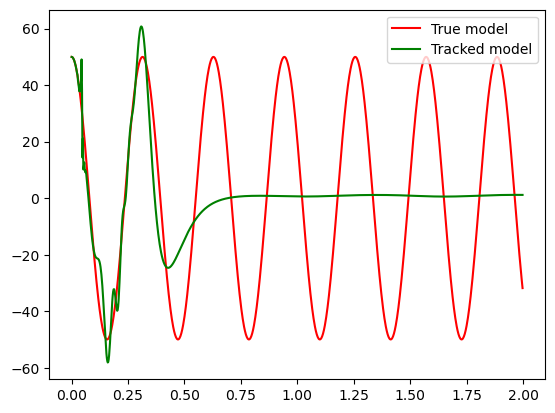

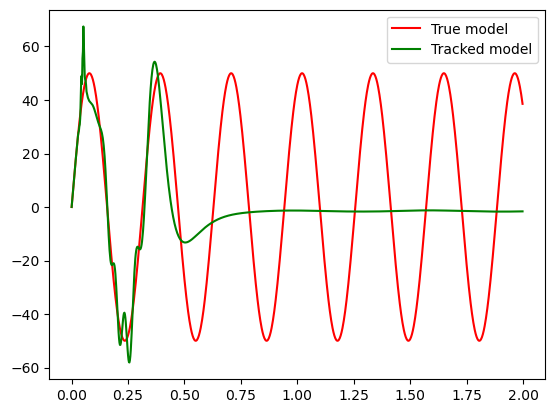

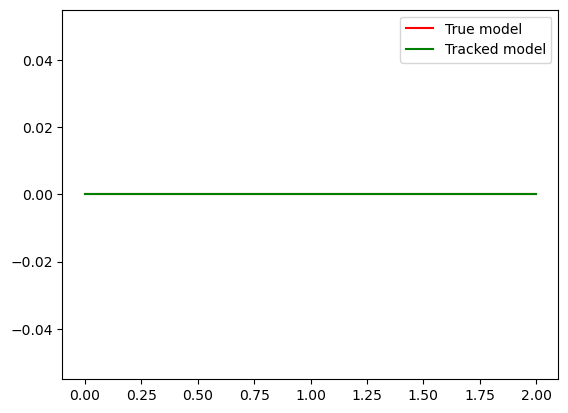

In [16]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r
    

    xp = sigma * (y - x) 
    yp = x * (rho - z) - y 
    zp = x * y - beta * z 

    x += dt * xp
    y += dt * yp
    z += dt * zp



    r = np.tanh(A.dot(r) + Win.dot(u) + 1)
    f[0, t] = 50 * np.cos(20 * t * dt)
    f[1, t] = 50 * np.sin(20 * t * dt)

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n))) 

### Testing

## Initializing testing parameters
Ttest = 10
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

xpred = np.zeros(ntraining)
ypred = np.zeros(ntraining)
zpred = np.zeros(ntraining)
xtrack, ytrack, ztrack = -7.45, -3.03, 0.01

for t in range(ntraining):

    ## Predictions using Wout matrix
    r = R[:, t]
    xtrack, ytrack, ztrack = Wout.dot(r)
    

    xpred[t] = xtrack
    ypred[t] = ytrack
    zpred[t] = ztrack


plottimerange = np.arange(0, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], f[0, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()


plt.figure()
plt.plot(testingtimes[plottimerange], f[1, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], f[2, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], zpred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()



Interesting. So it learnt to make the weights that are connected to z should be 0. For x and y, it learns for a few seconds, then it just goes to 0. I think it's because it probably learnt that it's periodic and the distances are going to go up and down, and the ridge regression is doing some funny business

In [17]:
Wout

array([[-35416.21380109,  11348.30141483,   2880.35931626, ...,
        -29385.51356429,    952.52739227,  -1896.31135237],
       [-31195.94665432, -11824.10157076,   -959.59851623, ...,
        -17347.45759255,  -5600.1593101 ,  -4617.92683268],
       [     0.        ,      0.        ,      0.        , ...,
             0.        ,      0.        ,      0.        ]])

I think the Wout martix is maybe too big? Going to try with a smaller reservoir

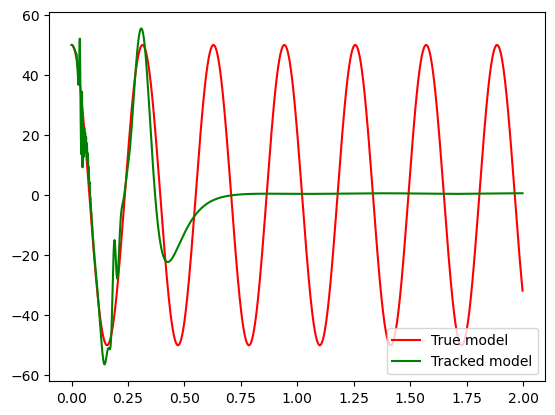

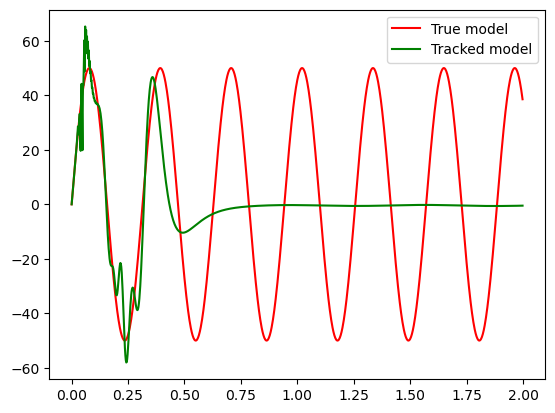

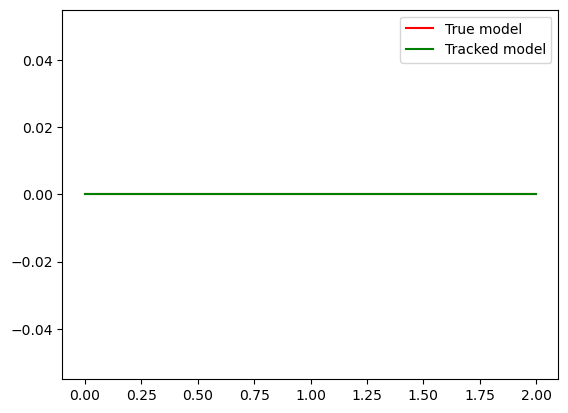

In [18]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 300                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r
    

    xp = sigma * (y - x) 
    yp = x * (rho - z) - y 
    zp = x * y - beta * z 

    x += dt * xp
    y += dt * yp
    z += dt * zp



    r = np.tanh(A.dot(r) + Win.dot(u) + 1)
    f[0, t] = 50 * np.cos(20 * t * dt)
    f[1, t] = 50 * np.sin(20 * t * dt)

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n))) 

### Testing

## Initializing testing parameters
Ttest = 10
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

xpred = np.zeros(ntraining)
ypred = np.zeros(ntraining)
zpred = np.zeros(ntraining)
xtrack, ytrack, ztrack = -7.45, -3.03, 0.01

for t in range(ntraining):

    ## Predictions using Wout matrix
    r = R[:, t]
    xtrack, ytrack, ztrack = Wout.dot(r)
    

    xpred[t] = xtrack
    ypred[t] = ytrack
    zpred[t] = ztrack


plottimerange = np.arange(0, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], f[0, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()


plt.figure()
plt.plot(testingtimes[plottimerange], f[1, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], f[2, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], zpred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()



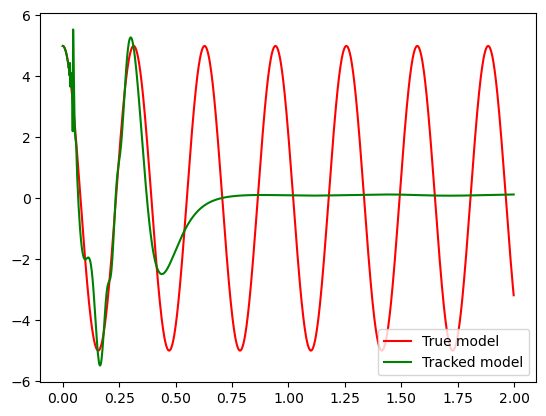

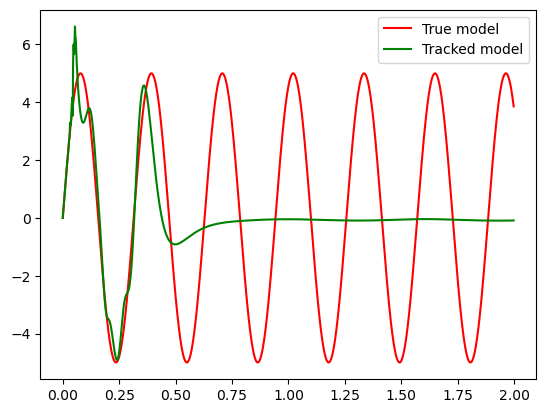

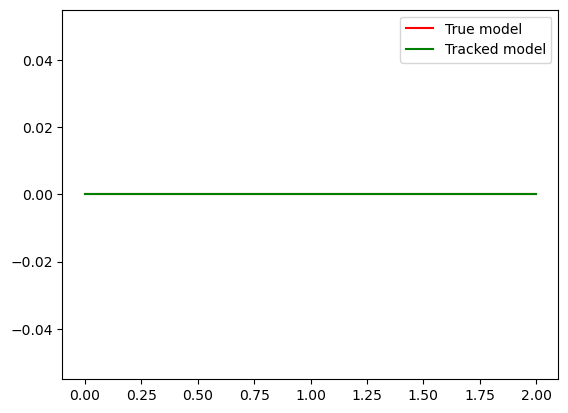

In [26]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 1000                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r
    

    xp = sigma * (y - x) 
    yp = x * (rho - z) - y 
    zp = x * y - beta * z 

    x += dt * xp
    y += dt * yp
    z += dt * zp



    r = np.tanh(A.dot(r) + Win.dot(u) + 1)
    f[0, t] = 5 * np.cos(20 * t * dt)
    f[1, t] = 5 * np.sin(20 * t * dt)

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n))) 

### Testing

## Initializing testing parameters
Ttest = 10
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

xpred = np.zeros(ntraining)
ypred = np.zeros(ntraining)
zpred = np.zeros(ntraining)
xtrack, ytrack, ztrack = -7.45, -3.03, 0.01

for t in range(ntraining):

    ## Predictions using Wout matrix
    r = R[:, t]
    xtrack, ytrack, ztrack = Wout.dot(r)
    

    xpred[t] = xtrack
    ypred[t] = ytrack
    zpred[t] = ztrack


plottimerange = np.arange(0, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], f[0, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()


plt.figure()
plt.plot(testingtimes[plottimerange], f[1, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], f[2, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], zpred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()



They kinda look like the taylor series approximation blowing up when it's not in the convergence region

Use Rossler instead. This is probably too simple and the reservoir can't learn it properly. But before that, what happens if I start at a different point.

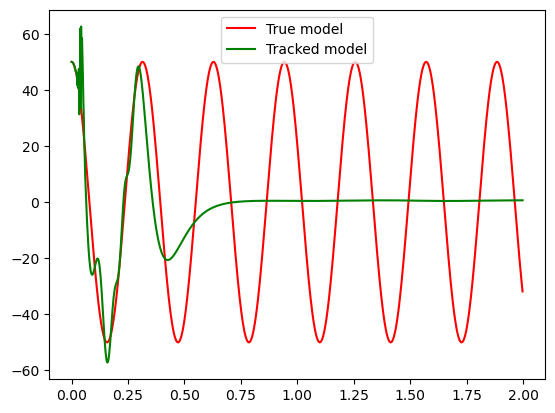

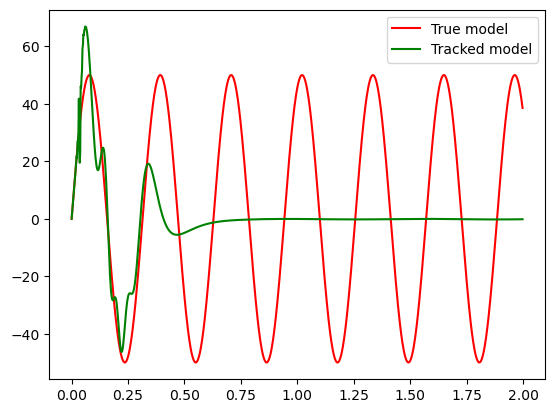

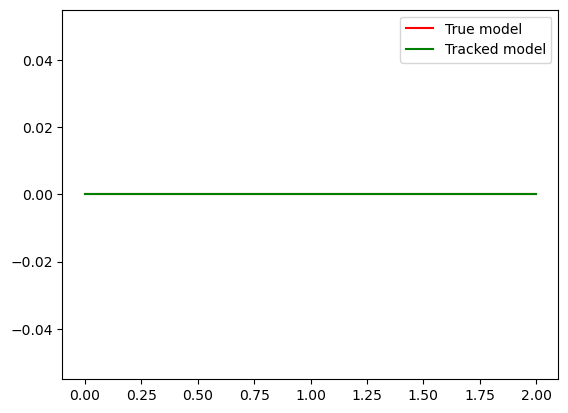

In [ ]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 300                    # reservoir size
m = 3                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z])
    R[:, t] = r
    

    xp = sigma * (y - x) 
    yp = x * (rho - z) - y 
    zp = x * y - beta * z 

    x += dt * xp
    y += dt * yp
    z += dt * zp



    r = np.tanh(A.dot(r) + Win.dot(u) + 1)
    f[0, t] = 50 * np.cos(20 * t * dt)
    f[1, t] = 50 * np.sin(20 * t * dt)

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n))) 

### Testing

## Initializing testing parameters
Ttest = 10
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

xpred = np.zeros(ntraining)
ypred = np.zeros(ntraining)
zpred = np.zeros(ntraining)

for t in range(ntraining):

    ## Predictions using Wout matrix
    r = R[:, t]
    xtrack, ytrack, ztrack = Wout.dot(r)
    

    xpred[t] = xtrack
    ypred[t] = ytrack
    zpred[t] = ztrack


plottimerange = np.arange(0, 1000)

plt.figure()
plt.plot(testingtimes[plottimerange], f[0, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()


plt.figure()
plt.plot(testingtimes[plottimerange], f[1, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], f[2, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], zpred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()



Fixing the dimensionality with bias term.

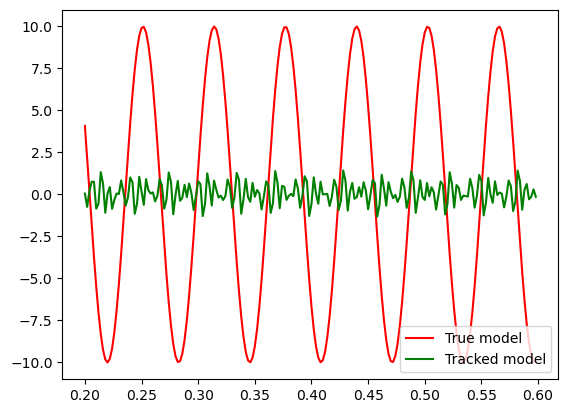

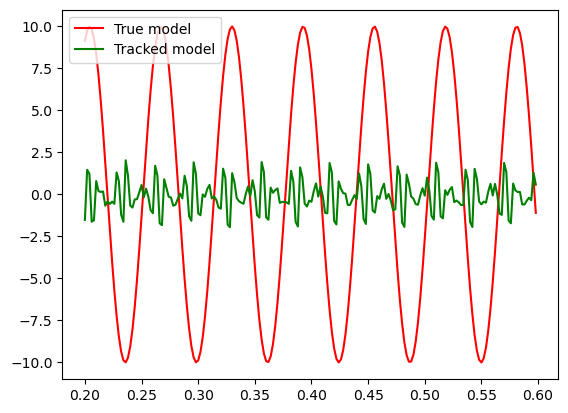

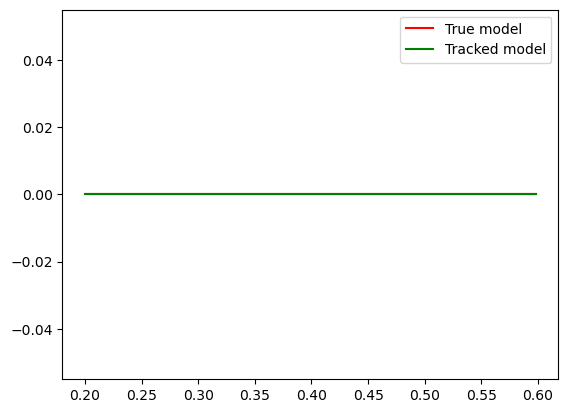

In [59]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 300                    # reservoir size
m = 3 + 1                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z, 1])
    R[:, t] = r
    

    xp = sigma * (y - x) 
    yp = x * (rho - z) - y 
    zp = x * y - beta * z 

    x += dt * xp
    y += dt * yp
    z += dt * zp



    r = np.tanh(A.dot(r) + Win.dot(u))
    f[0, t] = 10 * np.cos(100 * t * dt)
    f[1, t] = 10 * np.sin(100 * t * dt)
    f[-1, t] = 1

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n))) 

### Testing

## Initializing testing parameters
Ttest = 10
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

xpred = np.zeros(ntest)
ypred = np.zeros(ntest)
zpred = np.zeros(ntest)

xtrack, ytrack, ztrack = x, y, z

for t in range(ntest):

    ## Predictions using Wout matrix
    r = np.tanh(A.dot(r) + Win.dot(np.array([xtrack, ytrack, ztrack, 1])))
    xtrack, ytrack, ztrack = Wout.dot(r)[: m-1]
    

    xpred[t] = xtrack
    ypred[t] = ytrack
    zpred[t] = ztrack


plottimerange = np.arange(100, 300)

plt.figure()
plt.plot(testingtimes[plottimerange], f[0, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()


plt.figure()
plt.plot(testingtimes[plottimerange], f[1, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], f[2, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], zpred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()



This is insane. It is somehow learning some underlying pattern, and tries to oscillate.

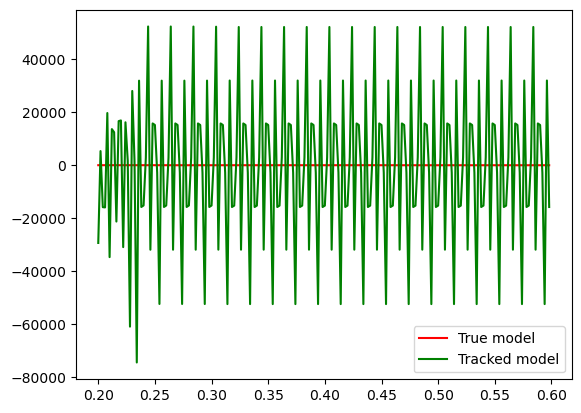

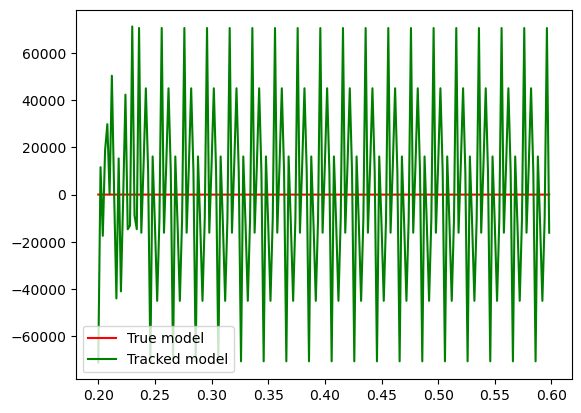

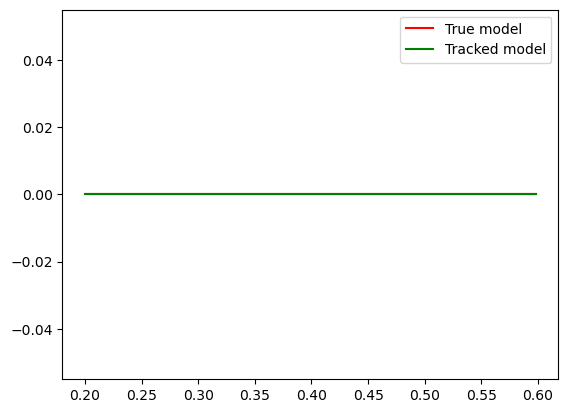

In [72]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 140
beta = 6

## Reservoir parameters
n = 300                    # reservoir size
m = 3 + 1                       # number of dimensions in the system  
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density=6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y, z = -7.45, -3.03, 0.01
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, z, 1])
    R[:, t] = r
    

    xp = sigma * (y - x) 
    yp = x * (rho - z) - y 
    zp = x * y - beta * z 

    x += dt * xp
    y += dt * yp
    z += dt * zp



    r = np.tanh(A.dot(r) + Win.dot(u))
    f[0, t] = 10 * np.cos(100 * t * dt)
    f[1, t] = 10 * np.sin(100 * t * dt)
    f[-1, t] = 1

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n))) 

### Testing

## Initializing testing parameters
Ttest = 10
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

xpred = np.zeros(ntest)
ypred = np.zeros(ntest)
zpred = np.zeros(ntest)

xtrack, ytrack, ztrack = x, y, z

for t in range(ntest):

    ## Predictions using Wout matrix
    r = np.tanh(A.dot(r) + Win.dot(np.array([xtrack, ytrack, ztrack, 1])))
    xtrack, ytrack, ztrack = Wout.dot(r)[: m-1]
    

    xpred[t] = xtrack
    ypred[t] = ytrack
    zpred[t] = ztrack


plottimerange = np.arange(100, 300)

plt.figure()
plt.plot(testingtimes[plottimerange], f[0, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()


plt.figure()
plt.plot(testingtimes[plottimerange], f[1, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()

plt.figure()
plt.plot(testingtimes[plottimerange], f[2, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], zpred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()



Maybe chaos is making it too difficult. Try with simple periodic oscillator.

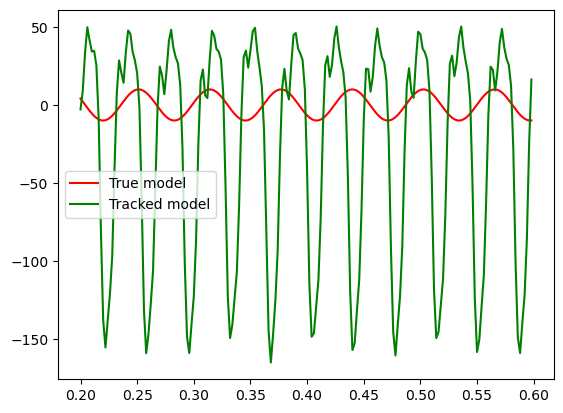

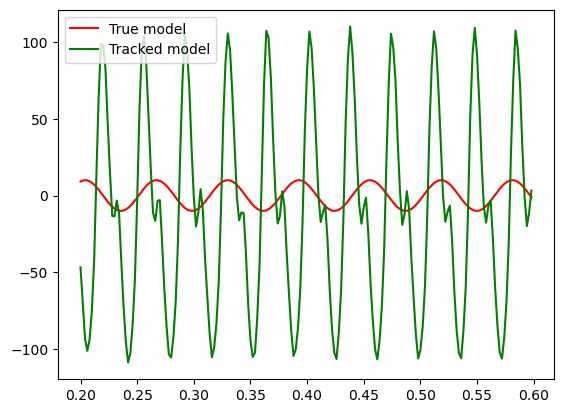

In [81]:
### Initializing parameters for training

## Lorenz system parameters 
sigma = 10
rho = 28
beta = 8/3

## Reservoir parameters
n = 300                    # reservoir size
m = 2 + 1                       # number of dimensions in the system + 1 for bias term 
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density = 6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x, y = -7.45, -3.03
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, 1])
    R[:, t] = r

    x = np.sin(2 * np.pi * t * dt)
    y = np.cos(2 * np.pi * t * dt)




    r = np.tanh(A.dot(r) + Win.dot(u))
    f[0, t] = 10 * np.cos(100 * t * dt)
    f[1, t] = 10 * np.sin(100 * t * dt)
    f[-1, t] = 1

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n))) 

### Testing

## Initializing testing parameters
Ttest = 10
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

xpred = np.zeros(ntest)
ypred = np.zeros(ntest)

xtrack, ytrack = x, y

for t in range(ntest):

    ## Predictions using Wout matrix
    r = np.tanh(A.dot(r) + Win.dot(np.array([xtrack, ytrack, 1])))
    xtrack, ytrack = Wout.dot(r)[: m-1]
    

    xpred[t] = xtrack
    ypred[t] = ytrack



plottimerange = np.arange(100, 300)

plt.figure()
plt.plot(testingtimes[plottimerange], f[0, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()


plt.figure()
plt.plot(testingtimes[plottimerange], f[1, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()


I think giving the difference of x with previous term, basically x_n - x_n-1, should make it easier for the reservoir to learn that we're dealing with differences and derivatives.

Gonna make the problem easier. Let's start with a monotonic continuous function, and try to map it to a different monotonic function using a reservoir.

In [ ]:
### Initializing parameters for training

## Reservoir parameters
n = 300                    # reservoir size
m = 1                       # number of dimensions in the system
mu = 1.2                      # Spectral radius of reservoir adjacency matrix
lam = 0.000001              # Lambda for ridge regression

## Simulation parameters
T = 100
dt = 0.002
ntraining = int(T / dt)
trainingtimes = np.linspace(0, T, ntraining + 1)


## Generate random sparse reservoir adjacency matrix A
A1 = sp.random(n, n, density = 6/n, format='csr')    # n x n sparse matrix with values between   
A1 = A1 - 0.5 * np.sign(A1.toarray())              # All non-zero terms are shifted left by 0.5
A1 = A1 * mu / np.abs(sp.linalg.eigs(A1, k=1)[0])  # normalize reservoir matrix 
A = sp.csr_matrix(A1)

## Generate random Win matrix to have entries with values between -0.01 to 0.01
Win = 0.01 * (2.0 * np.random.rand(n, m) - 1)

### Training reservoir to model the system

## Inital state of Lorenz system, time-series data of reservoir states R 
## and time-series data of system states f
x = -7.45
R = np.zeros((n, ntraining))
f = np.zeros((m, ntraining))

## Generate random intial state for reservoir with values between -0.5 to 0.5
r = 0.5 - 1.0 * np.random.rand(n)

## Collecting reservoir time-series data
for t in range(ntraining):

    u = np.array([x, y, 1])
    R[:, t] = r

    x = np.sin(2 * np.pi * t * dt)
    y = np.cos(2 * np.pi * t * dt)




    r = np.tanh(A.dot(r) + Win.dot(u))
    f[0, t] = 10 * np.cos(100 * t * dt)
    f[1, t] = 10 * np.sin(100 * t * dt)
    f[-1, t] = 1

## Finding Wout matrix using ridge regression
Wout = f.dot(R.T).dot(np.linalg.inv(R.dot(R.T) + lam * np.eye(n))) 

### Testing

## Initializing testing parameters
Ttest = 10
ntest = int(Ttest / dt)
testingtimes = np.linspace(0, Ttest, ntest + 1)

xpred = np.zeros(ntest)
ypred = np.zeros(ntest)

xtrack, ytrack = x, y

for t in range(ntest):

    ## Predictions using Wout matrix
    r = np.tanh(A.dot(r) + Win.dot(np.array([xtrack, ytrack, 1])))
    xtrack, ytrack = Wout.dot(r)[: m-1]
    

    xpred[t] = xtrack
    ypred[t] = ytrack



plottimerange = np.arange(100, 300)

plt.figure()
plt.plot(testingtimes[plottimerange], f[0, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], xpred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()


plt.figure()
plt.plot(testingtimes[plottimerange], f[1, plottimerange], 'r', label = 'True model')
plt.plot(testingtimes[plottimerange], ypred[plottimerange],  'g', label = 'Tracked model')
plt.legend()
plt.show()
